In [1]:
import numpy as np
import torch

from prob_mbrl import utils, models, algorithms, losses, train_regressor, envs
torch.set_flush_denormal(True)
torch.set_num_threads(1)

In [2]:
# parameters
n_rnd = 4
H = 40
N_particles = 100
dyn_components = 1
dyn_hidden = [200]*2
pol_hidden = [200]*2
use_cuda = True
learn_reward = False

# initialize environment
env = envs.Cartpole()
env.dt = env.model.dt
D = env.observation_space.shape[0]
U = env.action_space.shape[0]
maxU = env.action_space.high

# initialize reward/cost function
if learn_reward or env.reward_func == None:
    reward_func = None
else:
    reward_func = env.reward_func

# initialize dynamics model
dynE = 2*(D+1) if learn_reward else 2*D
if dyn_components > 1:
    output_density = models.MixtureDensity(dynE/2, dyn_components)
    dynE = (dynE+1)*dyn_components
    log_likelihood_loss = losses.gaussian_mixture_log_likelihood
else:
    output_density = models.DiagGaussianDensity(dynE/2)
    log_likelihood_loss = losses.gaussian_log_likelihood

dyn_model = models.dropout_mlp(
            D+U, dynE, dyn_hidden,
            dropout_layers=[models.modules.CDropout(0.5, 0.1)
                            for i in range(len(dyn_hidden))],
            nonlin=torch.nn.ReLU
        )
dyn = models.DynamicsModel(
    dyn_model, reward_func=reward_func,
    output_density=output_density).float()

# initalize policy
pol_model = models.dropout_mlp(
        D, U, pol_hidden,
        dropout_layers=[models.modules.BDropout(0.1)
                        for i in range(len(pol_hidden))],
        nonlin=torch.nn.ReLU,
        weights_initializer=torch.nn.init.xavier_normal_,
        biases_initializer=None,
        output_nonlin=torch.nn.Tanh)

pol = models.Policy(pol_model, maxU).float()

# initalize experience dataset
exp = utils.ExperienceDataset()

# initialize dynamics optimizer
opt1 = torch.optim.Adam(dyn.parameters(), 1e-3)

# initialize policy optimizer
opt2 = torch.optim.Adam(pol.parameters(), 1e-3)

apply_controller Starting run
apply_controller Running for 4.000000 seconds
apply_controller Done. Stopping robot. Value of run [0.069375]
apply_controller Starting run
apply_controller Running for 4.000000 seconds
apply_controller Done. Stopping robot. Value of run [0.010419]
apply_controller Starting run
apply_controller Running for 4.000000 seconds
apply_controller Done. Stopping robot. Value of run [0.181430]
apply_controller Starting run
apply_controller Running for 4.000000 seconds


log-likelihood of data: -2.163342:   1%|          | 11/2000 [00:00<00:34, 57.81it/s] 

apply_controller Done. Stopping robot. Value of run [0.158740]


log-likelihood of data: 5.670359: 100%|█████████▉| 1996/2000 [00:15<00:00, 127.07it/s]


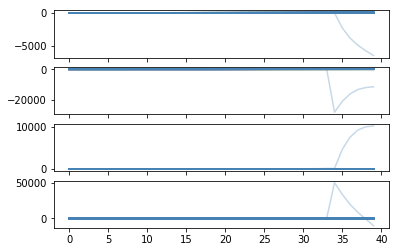

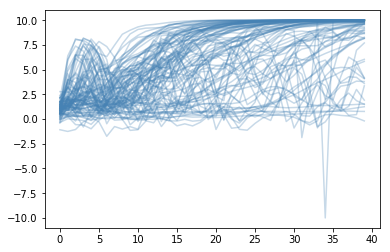

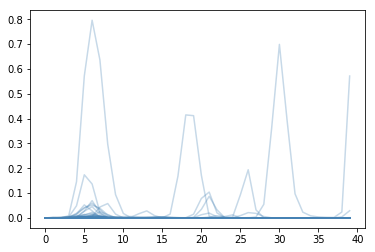

/home/juancamilog/miniconda2/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Accumulated rewards: 0.000132:   0%|          | 1/1000 [00:00<02:15,  7.37it/s]

Policy search iteration 1


Accumulated rewards: 0.331279: 100%|██████████| 1000/1000 [02:26<00:00,  6.81it/s]


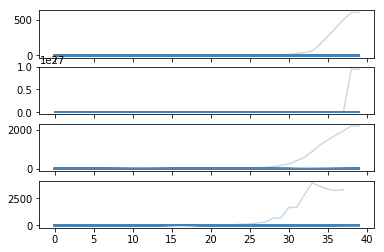

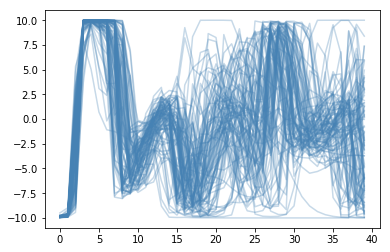

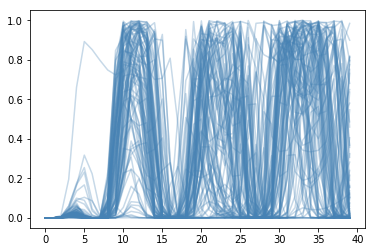

apply_controller Starting run
apply_controller Running for 4.000000 seconds


log-likelihood of data: -0.384585:   1%|          | 13/2000 [00:00<00:29, 67.60it/s] 

apply_controller Done. Stopping robot. Value of run [1.071662]


log-likelihood of data: 7.537046: 100%|█████████▉| 1990/2000 [00:18<00:00, 109.13it/s]


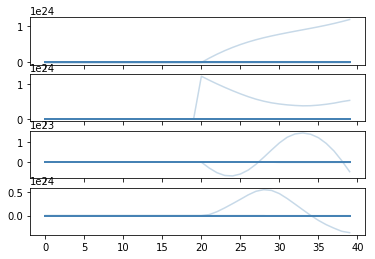

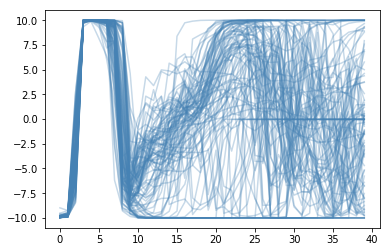

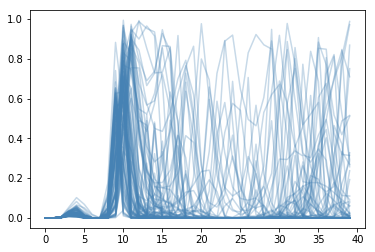

Accumulated rewards: 0.062248:   0%|          | 1/1000 [00:00<02:13,  7.48it/s]

Policy search iteration 2


Accumulated rewards: 0.332105: 100%|██████████| 1000/1000 [02:33<00:00,  6.49it/s]


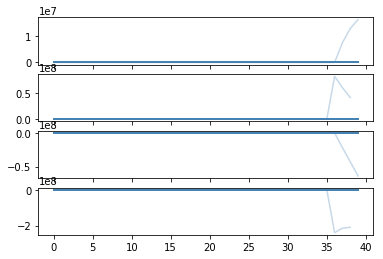

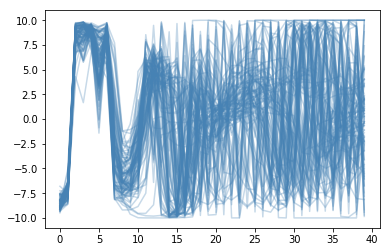

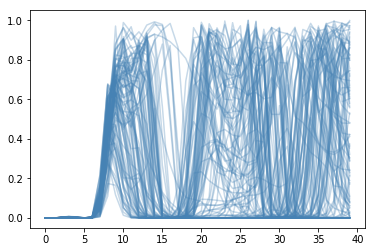

apply_controller Starting run
apply_controller Running for 4.000000 seconds


log-likelihood of data: 1.926195:   1%|          | 13/2000 [00:00<00:29, 66.84it/s] 

apply_controller Done. Stopping robot. Value of run [1.693210]


log-likelihood of data: 10.237885: 100%|█████████▉| 1997/2000 [00:16<00:00, 120.29it/s]


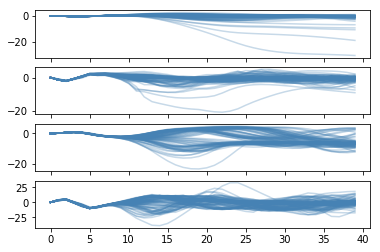

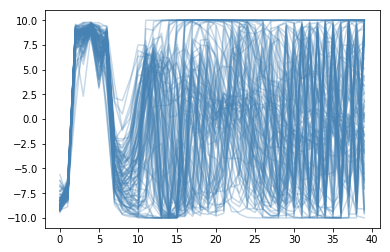

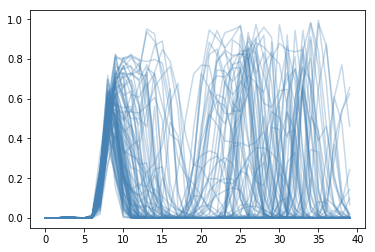

Accumulated rewards: 0.100706:   0%|          | 1/1000 [00:00<02:08,  7.79it/s]

Policy search iteration 3


Accumulated rewards: 0.227060:  40%|███▉      | 398/1000 [00:55<01:24,  7.16it/s]

In [ ]:
if use_cuda and torch.cuda.is_available():
    dyn = dyn.cuda()
    pol = pol.cuda()

# policy learning loop
for it in range(100+n_rnd):
    if it < n_rnd:
        pol_ = lambda x, t: maxU*(2*np.random.rand(U,)-1)
    else:
        pol_ = pol

    # apply policy
    ret = utils.apply_controller(
        env, pol_, H,
        callback=lambda *args, **kwargs: env.render())
    exp.append_episode(*ret)
    
    if it < n_rnd-1:
        continue
    ps_it = it - n_rnd + 1
    
    # train dynamics
    X, Y = exp.get_dynmodel_dataset(deltas=True, return_costs=learn_reward)
    dyn.set_dataset(
        torch.tensor(X).to(dyn.X.device).float(),
        torch.tensor(Y).to(dyn.X.device).float())
    train_regressor(
        dyn, 2000, N_particles, True, opt1,
        log_likelihood=log_likelihood_loss)

    # sample initial states for policy optimization
    x0 = torch.tensor(
        exp.sample_states(N_particles, timestep=0)).to(dyn.X.device).float()
    x0 += 1e-1*x0.std(0)*torch.randn_like(x0)
    utils.plot_rollout(x0, dyn, pol, H)

    # train policy
    print "Policy search iteration %d" % (ps_it + 1)
    algorithms.mc_pilco(
        x0, dyn, pol, H, opt2, exp, 1000,
        pegasus=True, mm_states=True, mm_rewards=False,
        maximize=True,  clip_grad=1.0)
    utils.plot_rollout(x0, dyn, pol, H)